# 02 - Recursive Chunking Strategy

Chunking documents based on different strategies will result in significant differences in search relevance. These differences vary based on the length of the documents being chunked. With the recursive chunking strategy we will split documents into discrete chunks using langchains recursive text splitter. This is aims to keep sections / paragraphs together within a certain boundary - working under the assumption that things within the same section or paragraph will be related.

For more information on this experiment and it's out

## Setting up the Experiment

Having ran [00-Chunking Strategies](./00-Chunking%20Strategies.ipynb) we now have our base data and our evaluation dataset. Now it's time to run our first experiment!

Given a dataframe containing our chunked documents we must:

- Chunk the documents
- Embed the chunks
- Store it in a vector database.
- Use a helper function to run the generation and evaluation

Let's follow our [recursive experiment](experiments/02-chunking-strategies-recursive.md). 

In [ ]:
import pandas as pd
from pathlib import Path
import mlflow
import os

# Params
top_k = 5
chunk_size = 1500
chunk_overlap = 100

# Models
generation_model = os.getenv('GEN_STEP_MODEL')
evaluation_model = os.getenv('EVAL_STEP_MODEL')

# Experiment
experiment_name = f"recursive_pubmed_articles_{chunk_size}_{chunk_overlap}_{top_k}"
evaluation_data = pd.read_csv('data/qa_pairs.csv')
input_data = pd.read_csv('data/docs_subset.csv')

# Check if the experiment already exists
experiment = mlflow.get_experiment_by_name(experiment_name)

if experiment is None:
    # If the experiment does not exist, create it
    experiment_id = mlflow.create_experiment(
        experiment_name,
        artifact_location=Path.cwd().joinpath("mlruns").as_uri(),
        tags={"version": "v1", "priority": "P1"},
    )
else:
    # If the experiment exists, get its ID
    experiment_id = experiment.experiment_id

mlflow.set_experiment(experiment_id)
   

#### Chunking the Documents

For this strategy, we'll look at using a recursive text splitter. [Langchain](https://python.langchain.com/docs/modules/data_connection/document_transformers/recursive_text_splitter/). This splitter attempts to keep paragraphs, sentences and words together as a proxy for semantic continuity. It can be fed a list of delimters to recursively split on, but the default is well suited to general text.

The function can also be configured to split various programming languages and files like Markdown.

> NOTE: The RecursiveCharacterTextSplitter measures chunks in terms of characters, not words or tokens.

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

if os.path.exists(f'data/{experiment_name}-chunks.csv'):
    print(f"Chunked data already exists at data/{experiment_name}-chunks.csv")
    ds_chunked = pd.read_csv(f'data/{experiment_name}-chunks.csv')
    print(f"Loaded {len(ds_chunked)} chunks")

else:
    text_splitter = RecursiveCharacterTextSplitter(
        # Set a really small chunk size, just to show.
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len,
        is_separator_regex=False,
    )

    # Create a new DataFrame with each chunk as a separate row
    chunks = []
    doc_ids = []
    chunk_ids = []
    for idx, row in input_data.iterrows():
        article_chunks = [chunk.page_content for chunk in text_splitter.create_documents([input_data['article'][idx]])]
        chunks.extend(article_chunks)
        doc_ids.extend([row['doc_id']] * len(article_chunks))
        chunk_ids.extend([f"{row['doc_id']}-{i+1}" for i in range(len(article_chunks))])

    ds_chunked = pd.DataFrame({'doc_id': doc_ids, 'chunk_id': chunk_ids, 'chunks': chunks})
    ds_chunked.to_csv(f'data/{experiment_name}-chunks.csv', index=False)

Let's take a look at some of our chunks - it helps to do a sense check as if we see something wrong, it's a lot easier to fix now than after creating your embeddings and search indexes.

In [ ]:
from pprint import pprint

# display a random sample of the chunked data show the full string
for chunk in ds_chunked['chunks'].sample(5):
    pprint(chunk)
    print('\n') 

Already we can see an improvement over the [baseline strategy](experiments/01-chunking-strategies-baseline.md), where the chunks were fragmented sentences. These appear to be more structured as we'd expect.

We can see that the chunks are of varying lengths. This is due to the recursive splitters preference to keeping grammatical structures together. Let's take a look at the distribution.

In [ ]:
# Lets use seaborn to plot the distribution of the chunk sizes
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(ds_chunked['chunks'].apply(lambda x: len(x.split())), kde=True)
plt.xlabel('Chunk Length (words)')
plt.show()


### Embed the Chunks and Load the Index

As before, we will use the `ada-v2` embedding model and the chroma database to create our index.

In [ ]:
import chromadb.utils.embedding_functions as embedding_functions
from dotenv import find_dotenv, load_dotenv
import os

load_dotenv(find_dotenv())   
# Specify Embedding model
embedding_model = os.getenv("AZURE_OPENAI_EMBEDDING_MODEL")

# Used in chromadb to embed docs and queries
openai_ef = embedding_functions.OpenAIEmbeddingFunction(
                api_key=os.getenv("AZURE_OPENAI_API_KEY"),
                api_base=os.getenv("AZURE_OPENAI_ENDPOINT"),
                api_type="azure",
                api_version=os.getenv("OPENAI_API_VERSION"),
                model_name=embedding_model
            )
# Create a new collection in ChromaDB
from chromadb import PersistentClient

chroma_client = PersistentClient(path="./data/chroma_db")

index_name = f"experiment_{experiment_name}"
collection = chroma_client.get_or_create_collection(name=index_name,embedding_function=openai_ef, metadata={"hnsw:space": "cosine"})

# Batch the embeddings into groups of 500 and add them to chroma
# This is necessary because there is an undocumented limit to the number of documents 
# That can be sent to the Azure API in a single request

for i in range(0, len(ds_chunked), 500):
    collection.add(
        documents=ds_chunked['chunks'].tolist()[i:i+500],
        metadatas=[{"doc_id": doc_id} for doc_id in ds_chunked['doc_id'][i:i+500]],
        ids=ds_chunked['chunk_id'].tolist()[i:i+500]
    )


## Run the Experiment and Evaluation

We will be using the same setup and evaluation as in the previous notebook, but this time we will run the experiment and the evaluation in one go. This can take around 5-10 minutes with GPT35 Turbo, so grab a coffee!

In [ ]:
from multiprocessing import Pool
from pprint import pprint
from helper.openai_utils import general_prompt, create_client
from rag.augmentation import get_context, contruct_prompt
from eval.evaluate import ragas_evaluate

multi_threading = True
oai_client = create_client()

if os.path.exists(f'data/{experiment_name}-{generation_model}-results.csv'):
    print("File exists, reading in...")
    import os
    import ast
    import pandas as pd
    from dotenv import find_dotenv, load_dotenv

    load_dotenv(find_dotenv())

    results_df = pd.read_csv(f'data/{experiment_name}-{generation_model}-results.csv')

    # Convert the contexts to a list of strings using ast
    results_df['contexts'] = results_df['contexts'].apply(ast.literal_eval)

else:
    #Create a distinct copy of evaluation_data to store the results
    results_df = evaluation_data.copy()

    def generation_step(question):
        context = get_context(question, collection,top_k)
        prompt = contruct_prompt(context, question)
        return general_prompt(oai_client, prompt, model=generation_model)

    if multi_threading == True:
        with Pool() as pool:
            results_multiprocessing = pool.map(generation_step, results_df['question'])
        results_df['answer'] = results_multiprocessing

    else:
        results_df['answer'] = results_df['question'].apply(lambda x: generation_step(x))

    #TODO: Refactor this so only one call for context

    # Check if the column exists
    if 'contexts' not in results_df.columns:
        results_df['contexts'] = [get_context(q, collection) for q in results_df['question']]

    #write out to CSV
    results_df.to_csv(f'data/{experiment_name}-{generation_model}-results.csv', index=False)


# Calculate metrics and store
import json
from eval.evaluate import ragas_evaluate

# check if csv and json files exist
if (os.path.exists(f'data/{experiment_name}-{generation_model}-{evaluation_model}-evaluated.csv') and 
    os.path.exists(f'data/{experiment_name}-{generation_model}-{evaluation_model}-evaluated.json')):

    print("File exists, reading in...")
    pd_results = pd.read_csv(f'data/{experiment_name}-{generation_model}-{evaluation_model}-evaluated.csv')
    
    with open(f'data/{experiment_name}-{generation_model}-{evaluation_model}-evaluated.json', 'r') as f:
        results = json.load(f)


else:
# Calculate metrics and store
    results = ragas_evaluate(results_df,evaluation_model=evaluation_model)
    with open(f'data/{experiment_name}-{generation_model}-{evaluation_model}-evaluated.json', 'w') as f:
        json.dump(results, f)
    pd_results = results.to_pandas()
    pd_results.to_csv(f'data/{experiment_name}-{generation_model}-{evaluation_model}-evaluated.csv', index=False)

from pprint import pprint
pprint(results)
display(pd_results)

with mlflow.start_run(experiment_id=experiment_id):
    mlflow.log_param("experiment_name", experiment_name)
    mlflow.log_param("top_k", top_k)
    mlflow.log_param("embedding_model", embedding_model)
    mlflow.log_param("generation_model", generation_model)
    mlflow.log_param("evaluation_model", evaluation_model)

    mlflow.log_metric("failthfulness", results['faithfulness'])
    mlflow.log_metric("answer_relevancy", results['answer_relevancy'])
    mlflow.log_metric("answer_similarity", results['answer_similarity'])

## Review the Ouput

Now that we have logged our experiment metrics. Let's compare and contrast them with the results of the baseline. 

In [ ]:
!mlflow server --host 127.0.0.1 --port 8080

We can now select the two experiments, and the runs that we are interested in comparing. Below are some examples from previous runs.

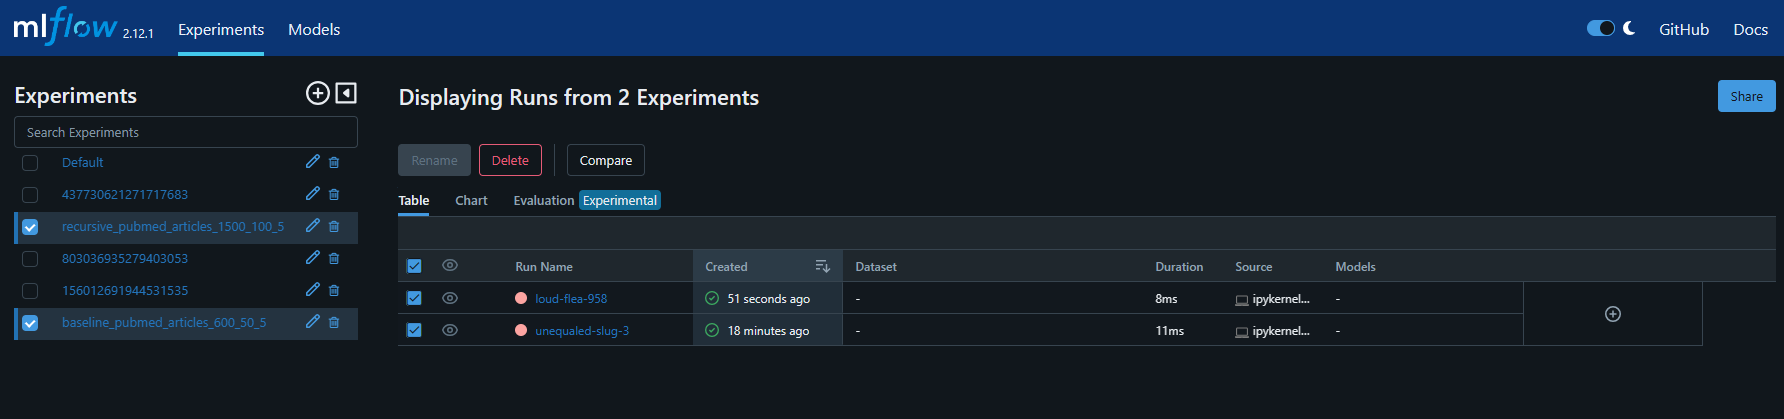

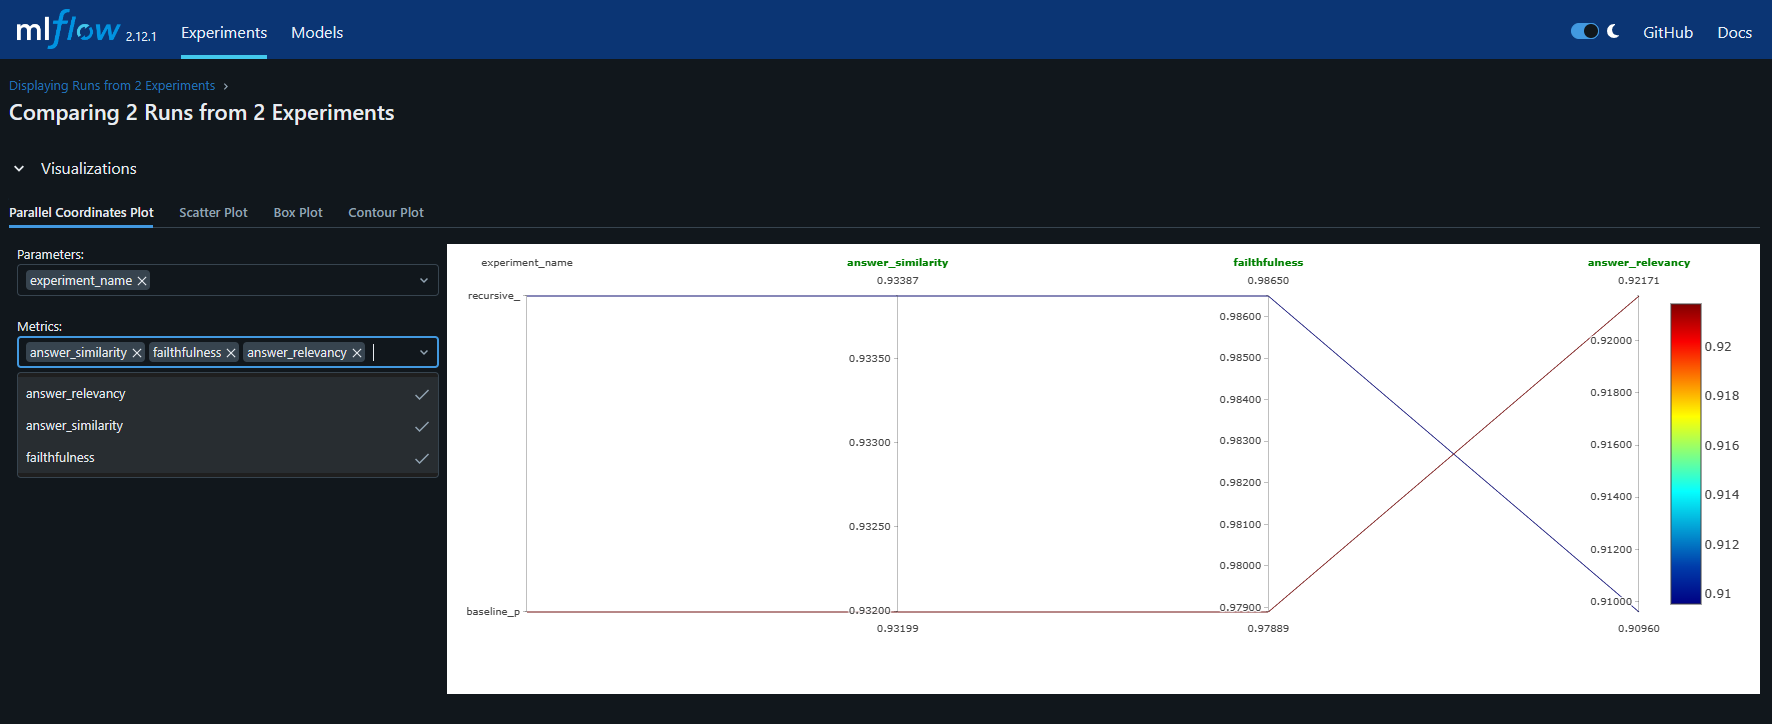

We can see that the recursive strategy ranks higher in similarity and faithfulness, but interestingly lower on answer relevancy.

As a reminder, here are the definitions:

1. *Faithfulness*: This measures the factual consistency of the generated answer against the given context. It is calculated from answer and retrieved context. The answer is scaled to (0,1) range. Higher the better.

2. *Answer Relevancy*: The evaluation metric, Answer Relevancy, focuses on assessing how pertinent the generated answer is to the given prompt. A lower score is assigned to answers that are incomplete or contain redundant information and higher scores indicate better relevancy.

3. *Answer Semantic Similarity*: The concept of Answer Semantic Similarity pertains to the assessment of the semantic resemblance between the generated answer and the ground truth. This evaluation is based on the ground truth and the answer, with values falling within the range of 0 to 1. A higher score signifies a better alignment between the generated answer and the ground truth.

We won't deep dive here on how how to reflect on these metrics, but a higher faithfulness takes into account the provided context, and the semantic similarity considers the ground truth. Assuming a sond ground truth dataset, improvements in these metrics may take preference over relevancy; provided relevancy stays above a given threshold.

So far, so good!

Let's compare these results to our baseline metrics and test to see if there's a difference. For this we will use [Mann-Whitney U test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) with an alpha of 0.05. This is similar to a ttest, but used when testing values that aren't normally distributed. 

*****--- Evaluation Comparison ---*****


,Baseline,Current,Baseline Std,Current Std
Faithfulness,0.947555,0.974960,0.110322,0.123614
Answer Relevancy,0.957002,0.911149,0.150584,0.210866
Answer Similarity,0.922239,0.936547,0.165479,0.059085


*****--- Distribution of metrics across experiments ---*****


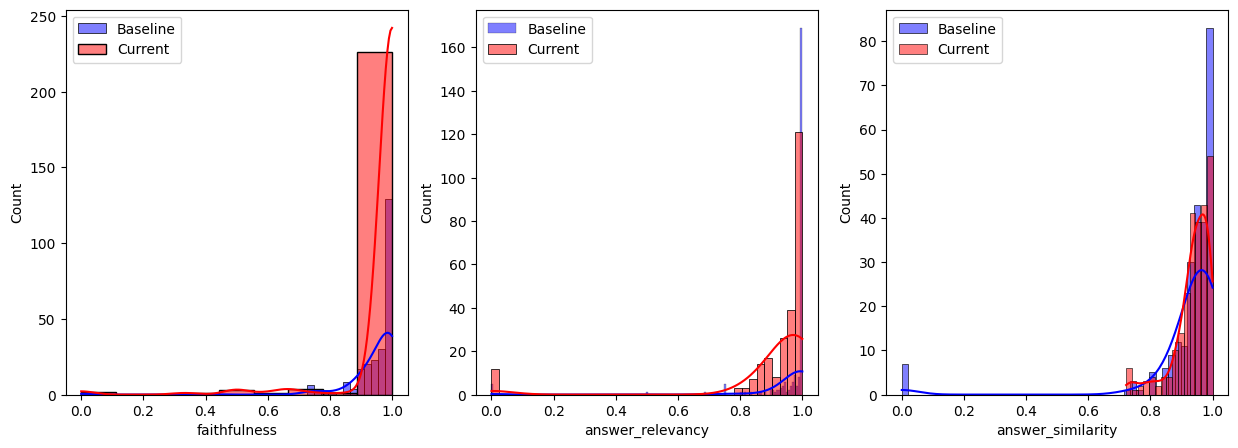

*****--- Distribution of differences ---*****


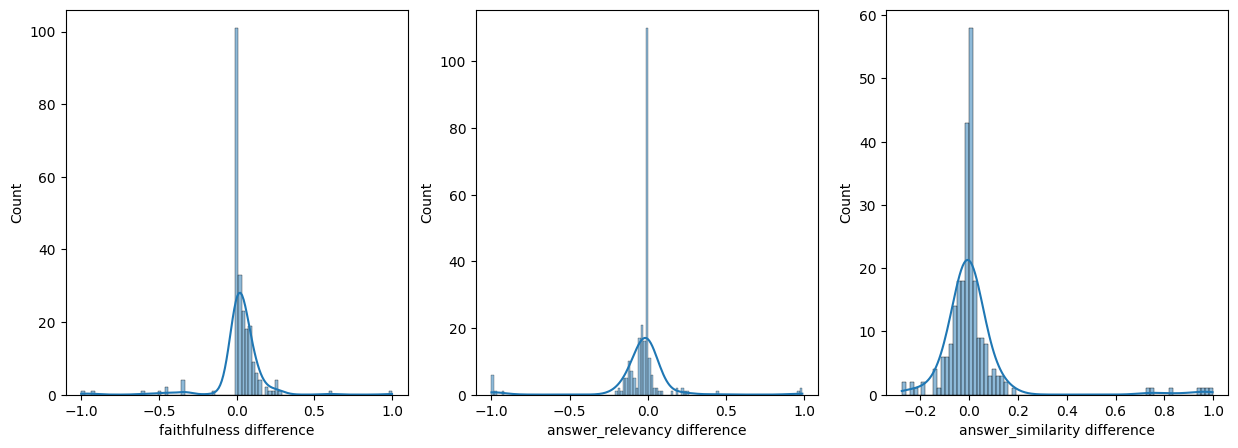

*****--- Mann-Whitney U Test ---*****
Null Hypothesis: The distribution of the metric is the same for the baseline and current results
Alternative Hypothesis: The distribution of the metric is different for the baseline and current results


faithfulness p-value: nan
answer_relevancy p-value: nan
answer_similarity p-value: 0.013814258244785313


In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

baseline_results = pd.read_csv('/home/guy/projects/aip/chunky_monkey/chunking_strategies/data/baseline_pubmed_articles_400_50_5-gpt-35-turbo-16k-gpt-35-turbo-16k-evaluated.csv')

current_results = pd.read_csv('data/recursive_pubmed_articles_1500_100_5-gpt-35-turbo-16k-gpt-35-turbo-16k-evaluated.csv')

# Visualise the difference in the metrics between the baseline and the current results using their means and standard deviations
# Create a table to display the results

evaluation_comp = pd.DataFrame({
    'Baseline': [baseline_results['faithfulness'].mean(), baseline_results['answer_relevancy'].mean(), baseline_results['answer_similarity'].mean()],
    'Current': [current_results['faithfulness'].mean(), current_results['answer_relevancy'].mean(), current_results['answer_similarity'].mean()],
    'Baseline Std': [baseline_results['faithfulness'].std(), baseline_results['answer_relevancy'].std(), baseline_results['answer_similarity'].std()],
    'Current Std': [current_results['faithfulness'].std(), current_results['answer_relevancy'].std(), current_results['answer_similarity'].std()],
}, index=['Faithfulness', 'Answer Relevancy', 'Answer Similarity'])

print("*****--- Evaluation Comparison ---*****")
display(evaluation_comp)


print("*****--- Distribution of metrics across experiments ---*****")

# Plot the distribution of the metrics for the baseline and current results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for idx, metric in enumerate(['faithfulness', 'answer_relevancy', 'answer_similarity']):
    sns.histplot(baseline_results[metric], kde=True, ax=axs[idx], color='blue', label='Baseline')
    sns.histplot(current_results[metric], kde=True, ax=axs[idx], color='red', label='Current')
    axs[idx].set_xlabel(metric)
    axs[idx].legend()

plt.show()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for idx, metric in enumerate(['faithfulness', 'answer_relevancy', 'answer_similarity']):
    sns.histplot(current_results[metric] - baseline_results[metric], kde=True, ax=axs[idx])
    axs[idx].set_xlabel(f"{metric} difference")

print("*****--- Distribution of differences ---*****")
plt.show()


# For each of the metrics, calculate the difference between the baseline and the current results
# The perform a statistical test to see if they are significantly different
# use the mann whitney u test
from scipy.stats import mannwhitneyu

print("*****--- Mann-Whitney U Test ---*****")
print("Null Hypothesis: The distribution of the metric is the same for the baseline and current results")
print("Alternative Hypothesis: The distribution of the metric is different for the baseline and current results")
print("\n")

for metric in ['faithfulness', 'answer_relevancy', 'answer_similarity']:
    baseline_metric = baseline_results[metric]
    current_metric = current_results[metric]

    # Perform the Mann-Whitney U test
    statistic, p_value = mannwhitneyu(baseline_metric, current_metric)

    print(f"{metric} p-value: {p_value}")



Here we can see a statistically significant difference on the answer similarity score, with 0.014 being below our alpha of 0.05. This means we can confidently say that recursive chunking strategy is an improvement on the baseline when it comes to this metric.

Great work!